In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 20190115

@author: zhangji

"""

%pylab inline
pylab.rcParams['figure.figsize'] = (25, 11)
fontsize = 40

import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d

from sympy import symbols, simplify, series, exp
from sympy.matrices import Matrix
from sympy.solvers import solve

from IPython.display import display, HTML
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import re
from scanf import scanf
import os
import glob
import importlib
from time import time

from codeStore import support_fun as spf
from src.support_class import *

rc('animation', html='html5')
PWD = os.getcwd()
font = {'size': 20}
matplotlib.rc('font', **font)
np.set_printoptions(linewidth=90, precision=5)


Populating the interactive namespace from numpy and matplotlib


In [27]:
def read_Liu_Fig2a_results(dir_name):
    t_dir = os.path.join(PWD, dir_name)
    txt_names = glob.glob('./%s/*.txt' % dir_name)

    psi2 = []
    psi3 = []
    psi61 = []
    psi62 = []
    ph = []
    zf = []
    uz = []
    for txt_name in txt_names:
        with open(txt_name, 'r') as ftxt:
            FILE_DATA = ftxt.read()

        text_headle = 'Translation, helix forces and torques \['
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=6)
        psi2.append(temp1[2])
        psi61.append(temp1[5])

        text_headle = 'Rotation, helix forces and torques \['
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=6)
        psi62.append(temp1[2])
        psi3.append(temp1[5])

        text_headle = 'helix pitch: '
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
        ph.append(temp1)

#         below is our definition of zf 
        text_headle = 'geometry zoom factor is '
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
        if np.isclose(temp1, 1):
            temp1 = 0
        zf.append(temp1)

#         # below is Liu Bin's definition of zf
#         text_headle = 'geometry zoom factor is '
#         temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
#         t_match = re.search('helix radius: \d+(\.\d+)? and \d+(\.\d+)?', FILE_DATA)
#         rh1, rh2 = scanf('helix radius: %f and %f', FILE_DATA[t_match.start():t_match.end()])
#         if np.isclose(temp1, 1):
#             temp1 = 0
#         temp1 = temp1 * (rh1 + rh2) / rh1
#         zf.append(temp1)
        
        text_headle = 'Norm forward helix velocity is '
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
        uz.append(temp1)

    data1 = pd.DataFrame({'ph':    np.hstack(ph), 
                          'zf':    np.hstack(zf), 
                          'psi2':  np.hstack(psi2), 
                          'psi3':  np.hstack(psi3), 
                          'psi61': np.hstack(psi61), 
                          'psi62': np.hstack(psi62),
                          'uz':    np.hstack(uz), })\
            .pivot_table(columns=['ph'], index=['zf'])

    psi2 = data1.psi2.T
    psi3 = data1.psi3.T
    psi61 = data1.psi61.T
    psi62 = data1.psi62.T
    uz = data1.uz.T
    return psi2, psi3, psi61, psi62, uz
#     data1 = pd.DataFrame({'ph':    np.hstack(ph), 
#                           'zf':    np.hstack(zf), 
#                           'psi2':  np.hstack(psi2), 
#                           'psi3':  np.hstack(psi3), 
#                           'psi61': np.hstack(psi61), 
#                           'psi62': np.hstack(psi62),
#                           'uz':    np.hstack(uz), })
#     return data1


In [111]:
psi62[[0, 0.7]]

zf,0.7
ph,
0.4,-0.010672
0.7,-0.094811
1.0,-0.339961
1.2,-0.628711
1.9,-2.519628
2.2,-3.682400
2.5,-4.981316
3.0,-7.293995
4.0,-11.873537


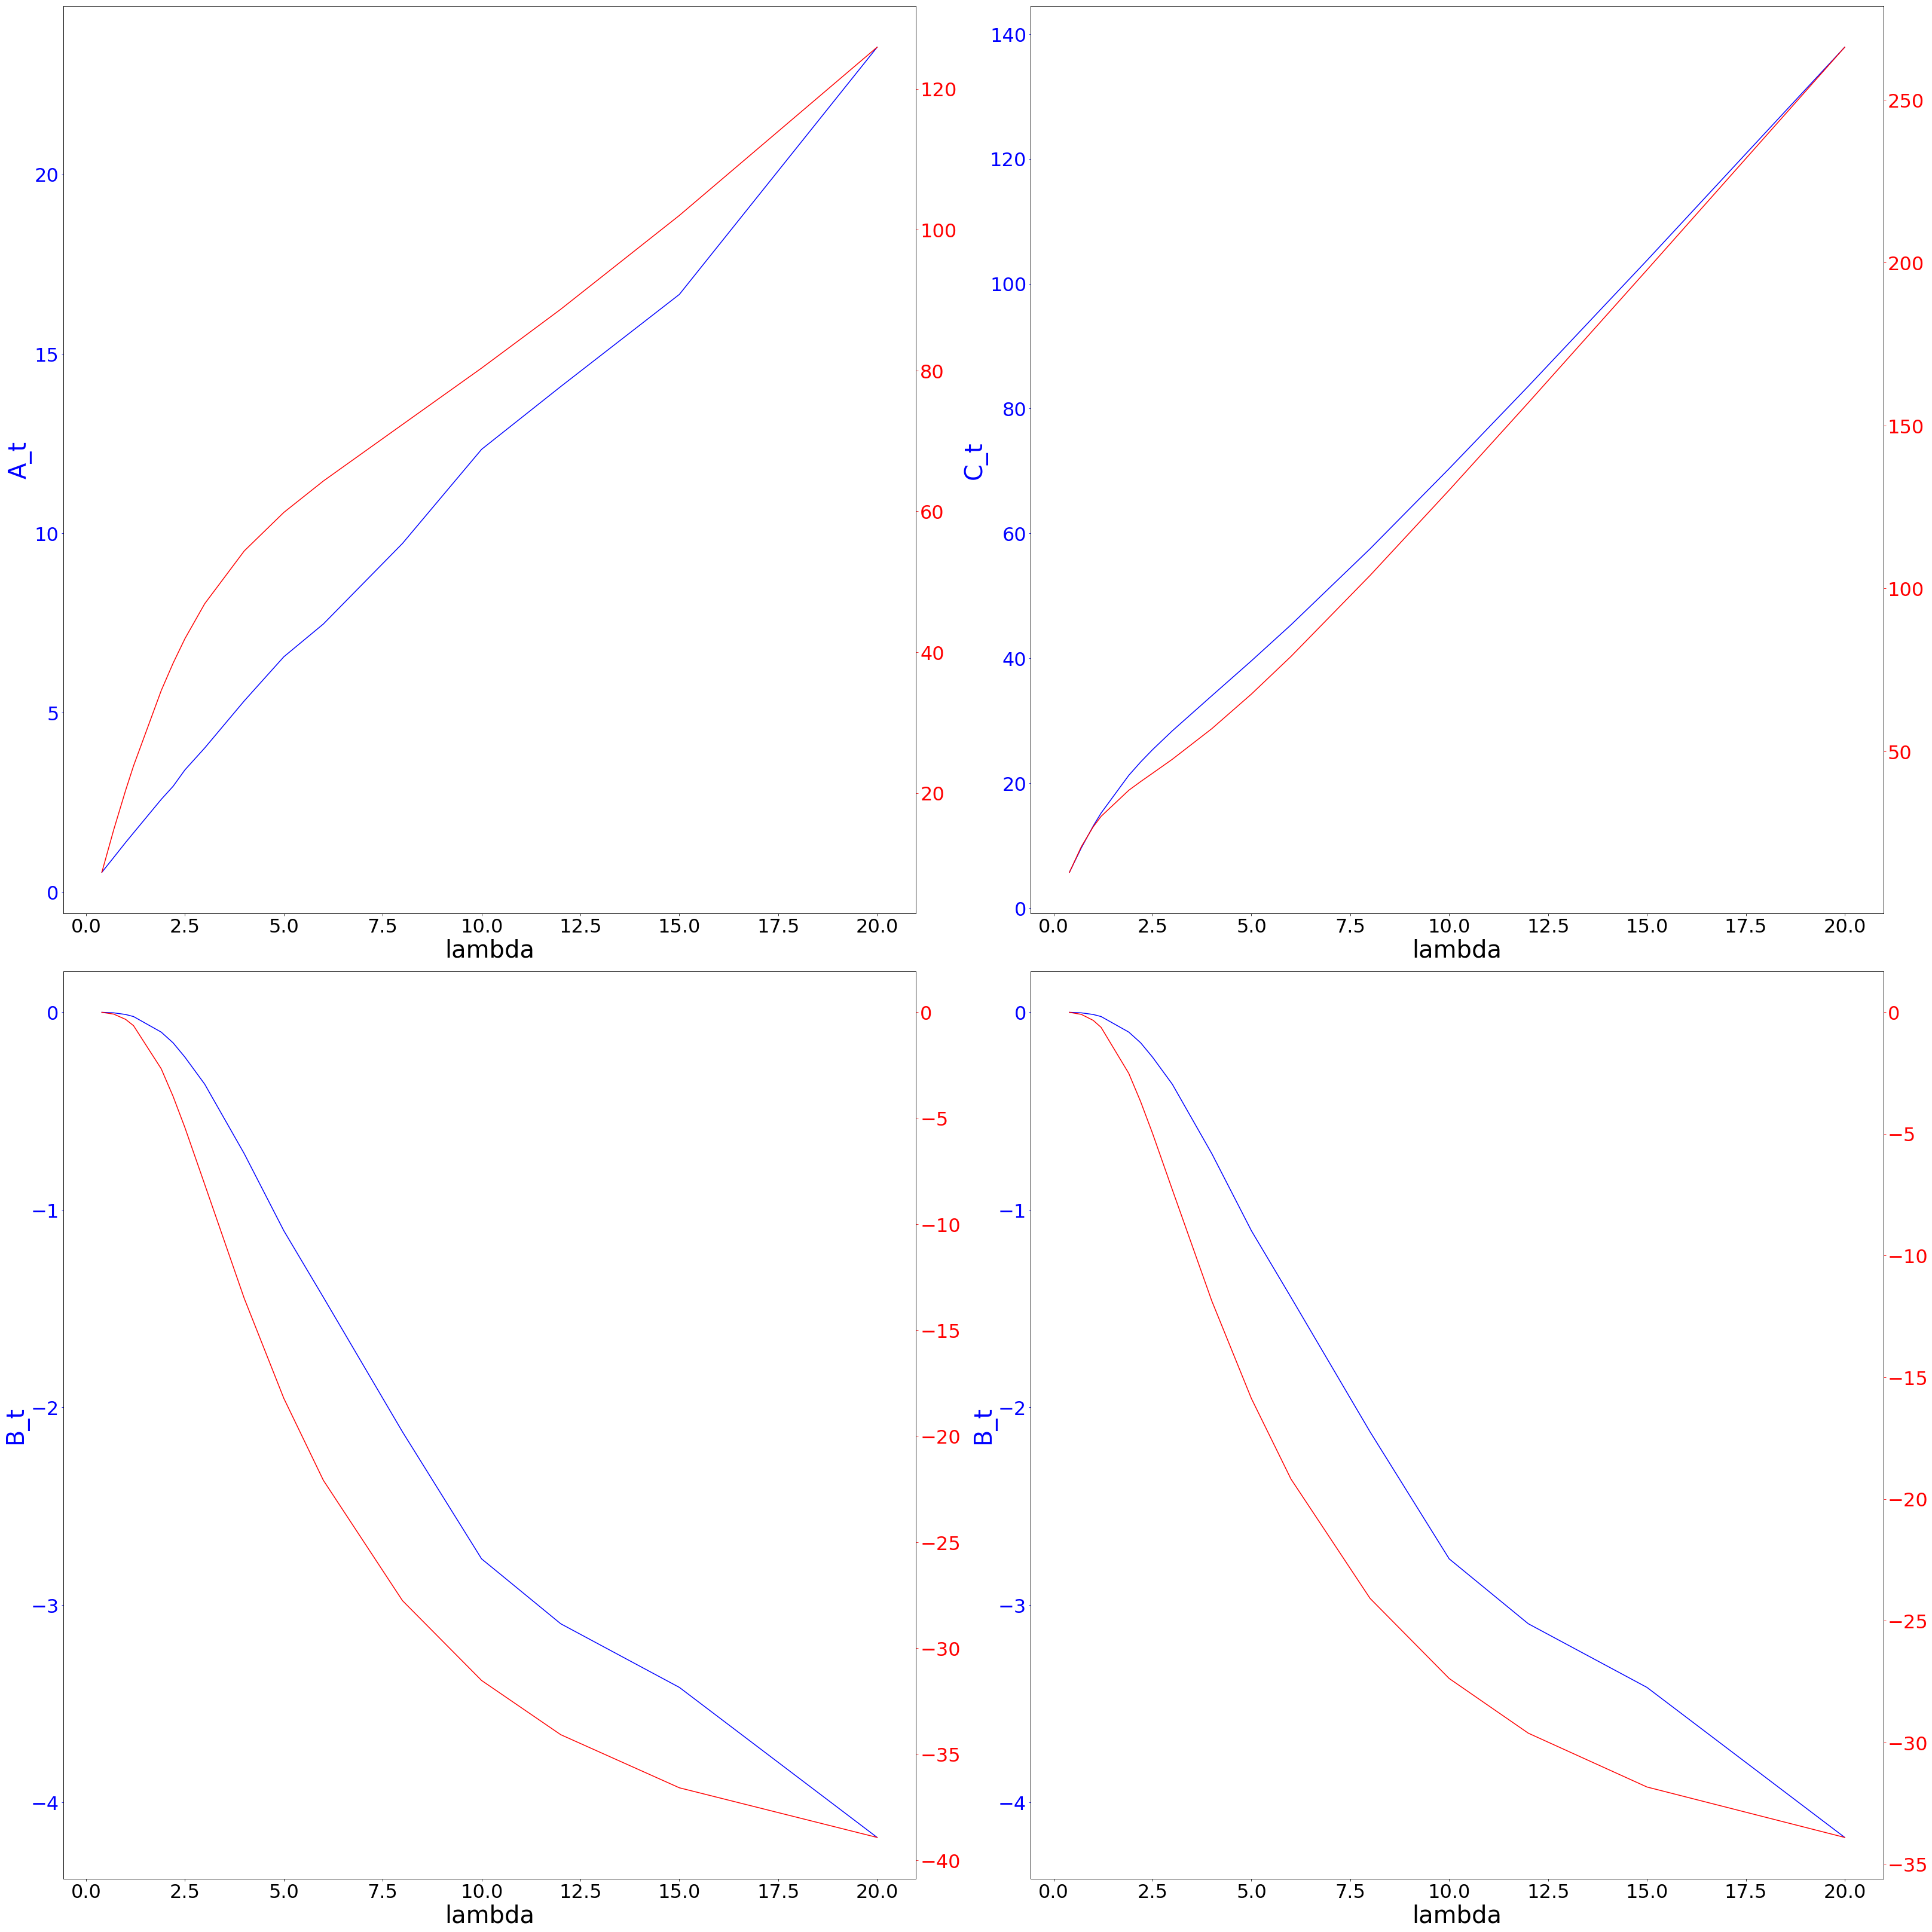

In [107]:
psi2, psi3, psi61, psi62, uz = read_Liu_Fig2a_results('try_ckeckInf2f')
psi6 = (psi61 + psi62) / 2
fig, ([ax0, ax1], [ax2, ax3]) = plt.subplots(nrows=2, ncols=2, figsize=(45, 45))
fig.patch.set_facecolor('white')
# At
ax0.plot(psi2.index.values, psi2[0], 'b')
ax0.set_xlabel('lambda', fontsize=fontsize, color='k')
ax0.set_ylabel('A_t', fontsize=fontsize, color='b')
ax0.tick_params('y', colors='b')
plt.sca(ax0)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
ax12 = ax0.twinx()
ax12.plot(psi2.index.values, psi2[0.7], 'r')
ax12.tick_params('y', colors='r')
plt.sca(ax12)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)

# Ct
ax1.plot(psi3.index.values, psi3[0], 'b')
ax1.set_xlabel('lambda', fontsize=fontsize, color='k')
ax1.set_ylabel('C_t', fontsize=fontsize, color='b')
ax1.tick_params('y', colors='b')
plt.sca(ax1)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
ax12 = ax1.twinx()
ax12.plot(psi3.index.values, psi3[0.7], 'r')
ax12.tick_params('y', colors='r')
plt.sca(ax12)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)

# Bt1
ax2.plot(psi61.index.values, psi61[0], 'b')
ax2.set_xlabel('lambda', fontsize=fontsize, color='k')
ax2.set_ylabel('B_t', fontsize=fontsize, color='b')
ax2.tick_params('y', colors='b')
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
ax12 = ax2.twinx()
ax12.plot(psi61.index.values, psi61[0.7], 'r')
ax12.tick_params('y', colors='r')
plt.sca(ax12)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)

# Bt2
ax3.plot(psi62.index.values, psi62[0], 'b')
ax3.set_xlabel('lambda', fontsize=fontsize, color='k')
ax3.set_ylabel('B_t', fontsize=fontsize, color='b')
ax3.tick_params('y', colors='b')
plt.sca(ax3)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
ax12 = ax3.twinx()
ax12.plot(psi62.index.values, psi62[0.7], 'r')
ax12.tick_params('y', colors='r')
plt.sca(ax12)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

# ft = -psi6 / psi3
# ut = ft / psi2
# at = ut.div(ut[0], axis=0)
# axat = at.plot()
# axat.set_ylabel('speed_up')
# axat.set_xlim(0, 5)

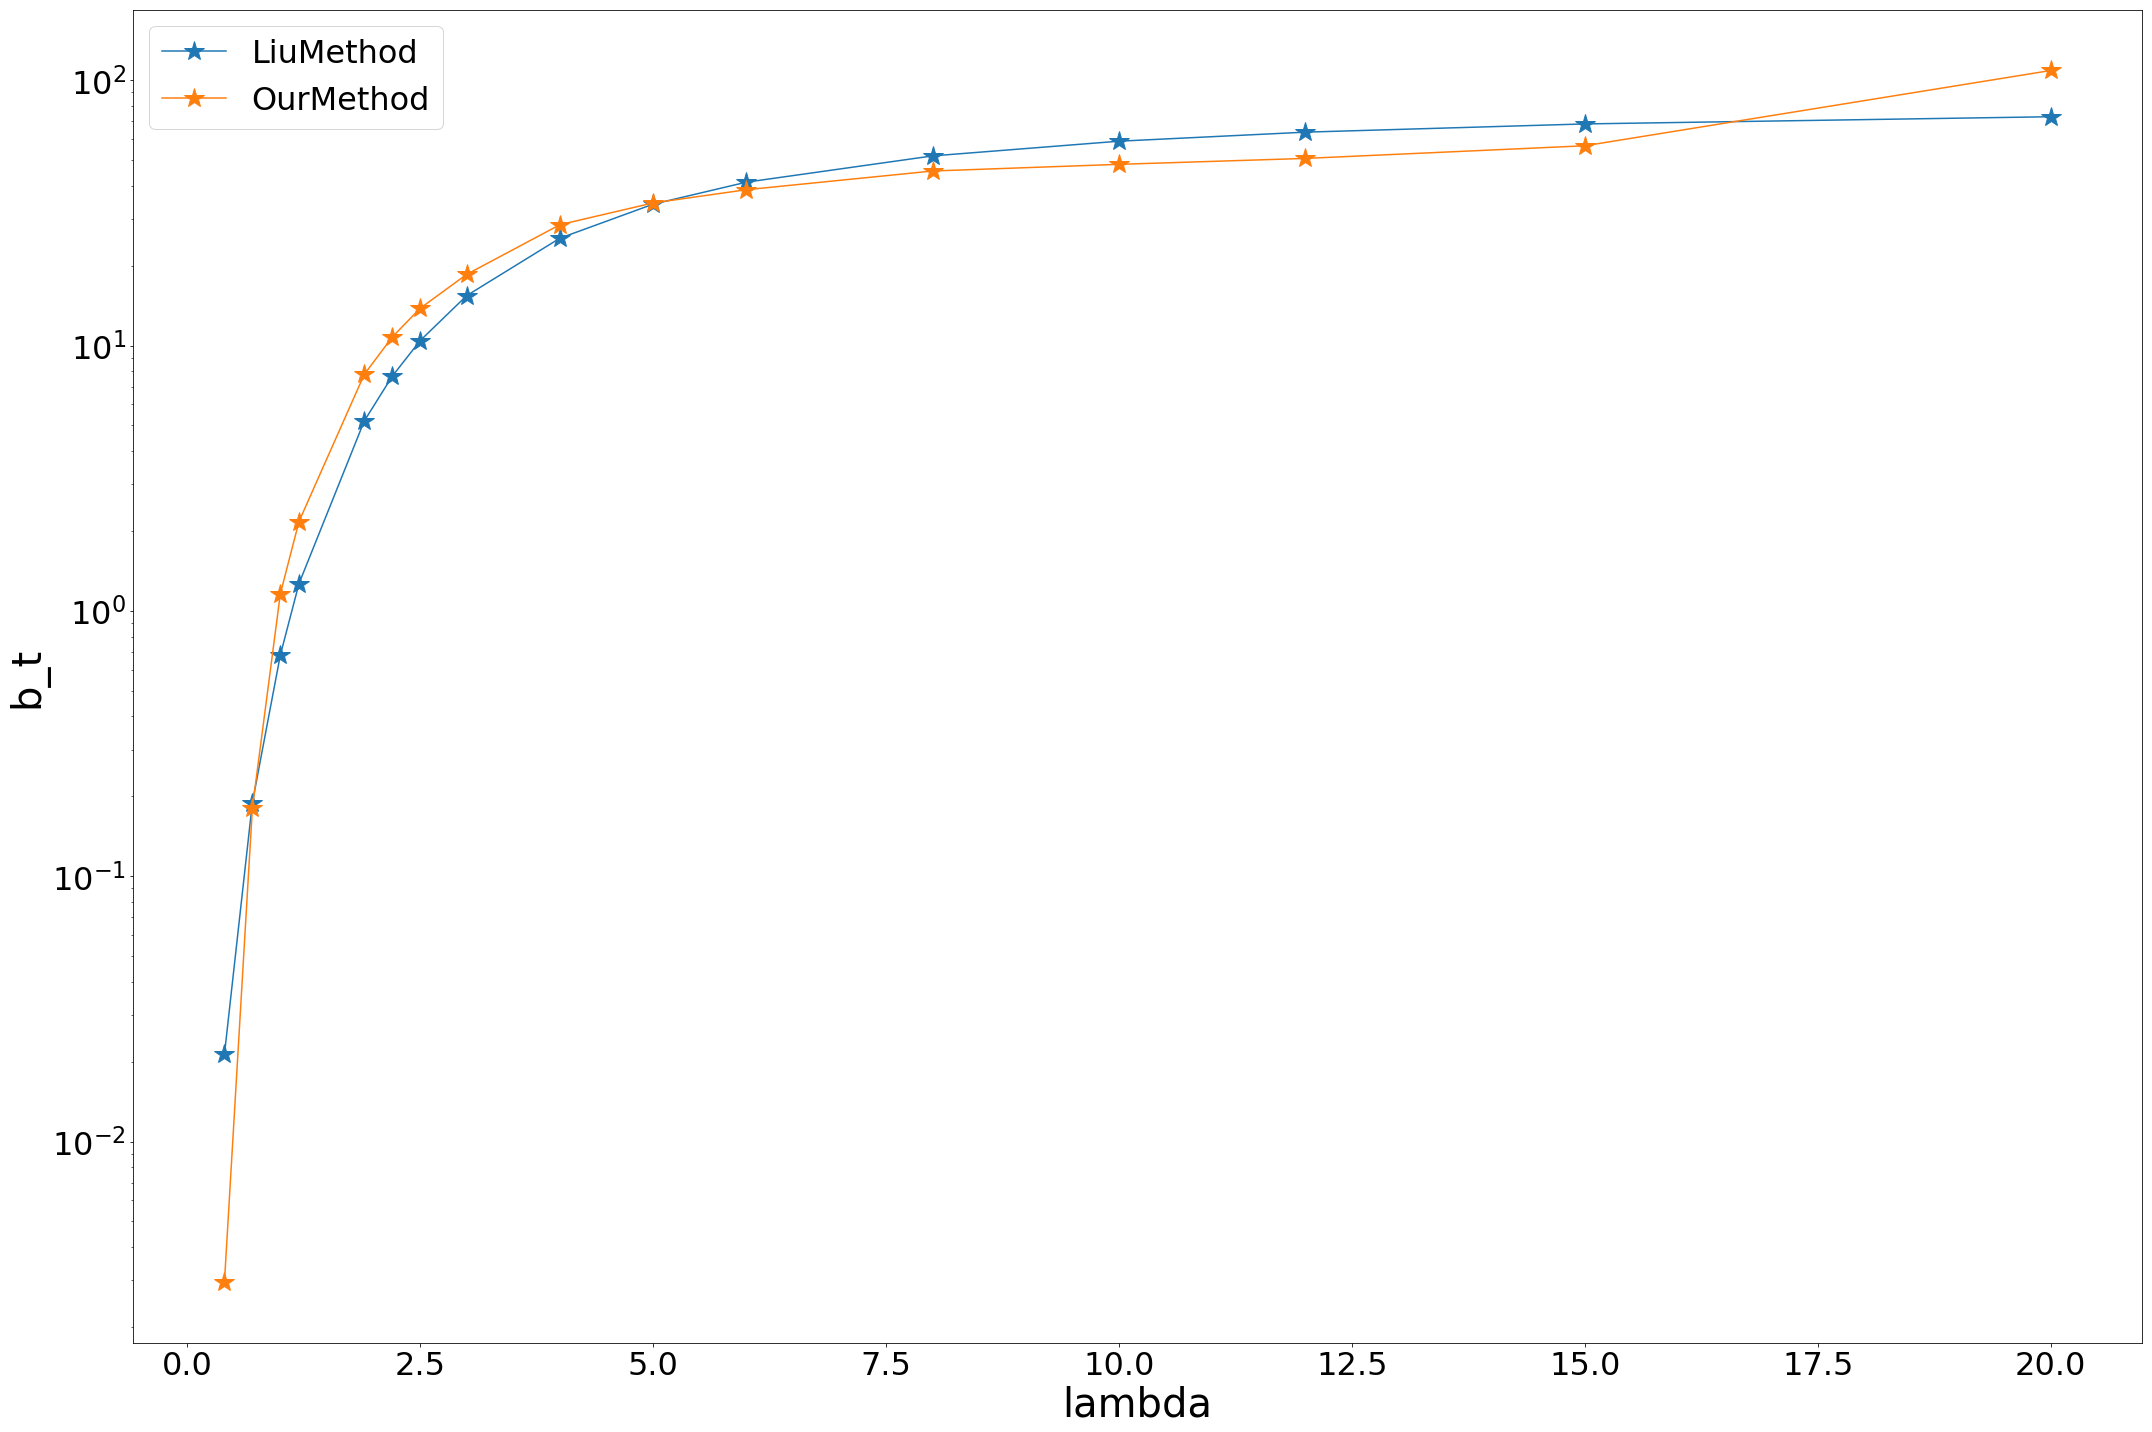

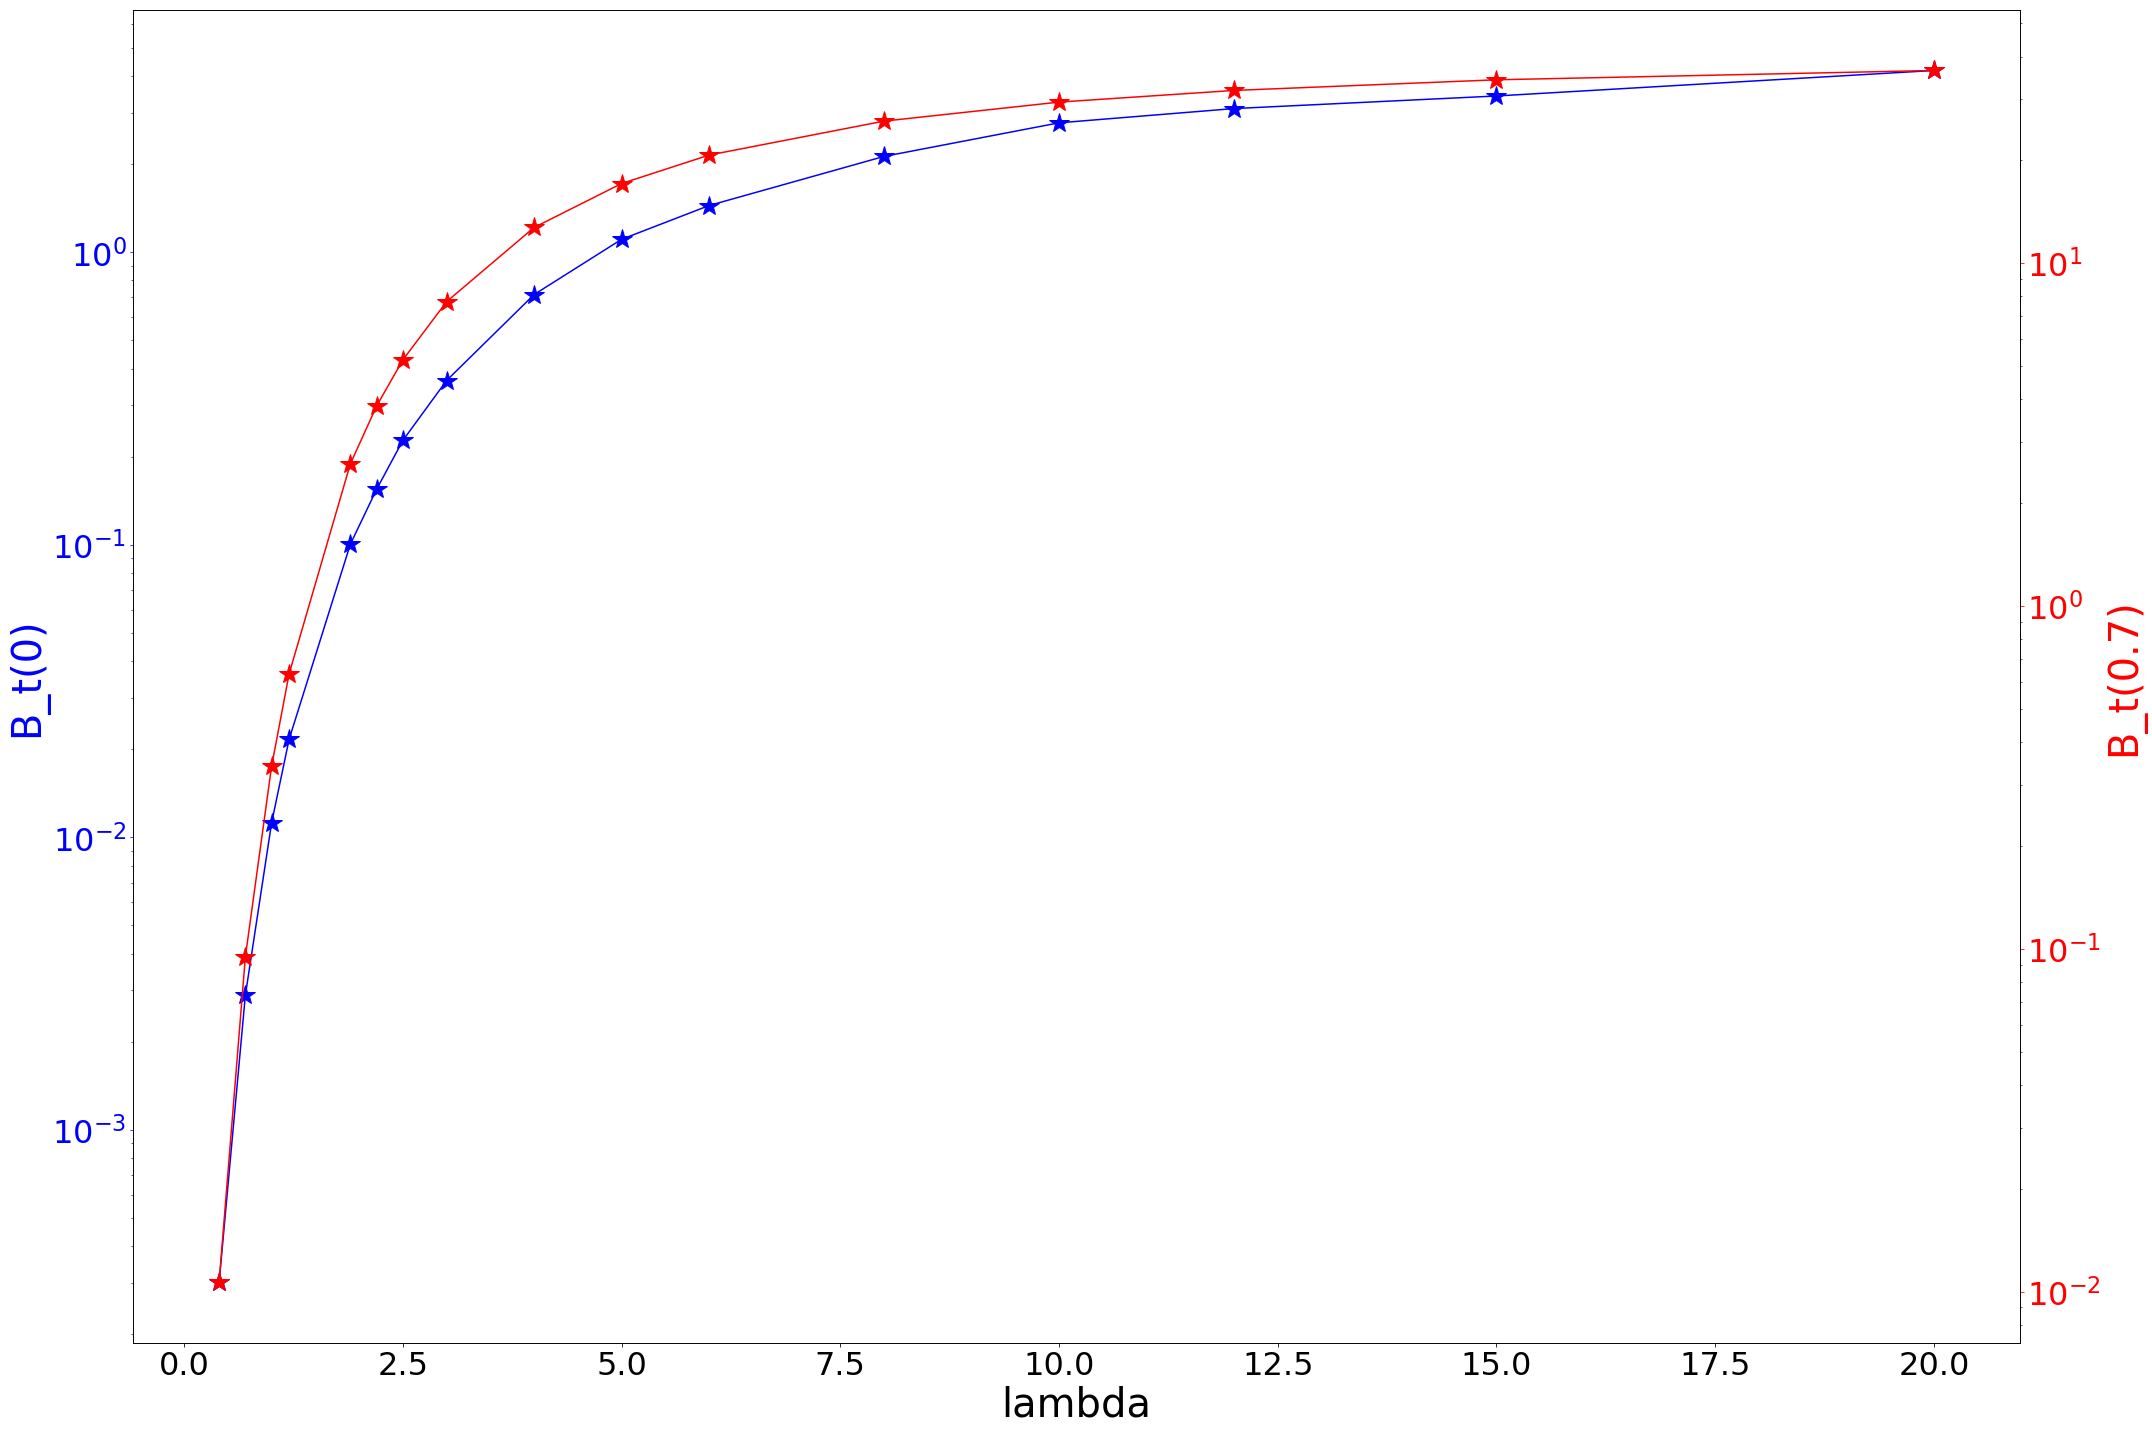

In [136]:
tx = np.array((0.4, 0.7, 1, 1.2, 1.9, 2.2, 2.5, 3, 4, 5, 6, 8, 10, 12, 15, 20, ))
ty1 = np.array((0.010661, 0.0947715, 0.3409795, 0.6334855, 2.5954145, 
                3.826751, 5.2156, 7.710861, 12.690398, 17.0468985, 20.634165, 
                25.923398, 29.4515, 31.852473, 34.2109695, 36.417422)) * 2
ty2 = np.array((0.00295, 0.181, 1.16, 2.171, 7.7785, 10.755, 13.81, 
                18.55, 28.535, 34.47, 38.655, 45.48, 48.185, 50.725, 56.61, 108.8, ))

psi2, psi3, psi61, psi62, uz = read_Liu_Fig2a_results('try_ckeckInf2f')
psi6 = (psi61 + psi62) / 2

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(30, 20))
fig.patch.set_facecolor('white')
ax0.semilogy(tx, ty1, '-*', label='LiuMethod', ms=fontsize*0.5)
ax0.semilogy(tx, ty2, '-*', label='OurMethod', ms=fontsize*0.5)
ax0.legend(fontsize=fontsize*0.8)
ax0.set_xlabel('lambda', fontsize=fontsize)
ax0.set_ylabel('b_t', fontsize=fontsize)
plt.sca(ax0)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(30, 20))
fig.patch.set_facecolor('white')
ax2.semilogy(psi6.index.values, -psi6[0], '-*b', ms=fontsize*0.5)
ax2.set_xlabel('lambda', fontsize=fontsize, color='k')
ax2.set_ylabel('B_t(0)', fontsize=fontsize, color='b')
ax2.tick_params('y', colors='b')
plt.sca(ax2)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
ax12 = ax2.twinx()
ax12.semilogy(psi6.index.values, -psi6[0.7], '-*r', ms=fontsize*0.5)
ax12.set_ylabel('B_t(0.7)', fontsize=fontsize, color='r')
ax12.tick_params('y', colors='r')
plt.sca(ax12)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()


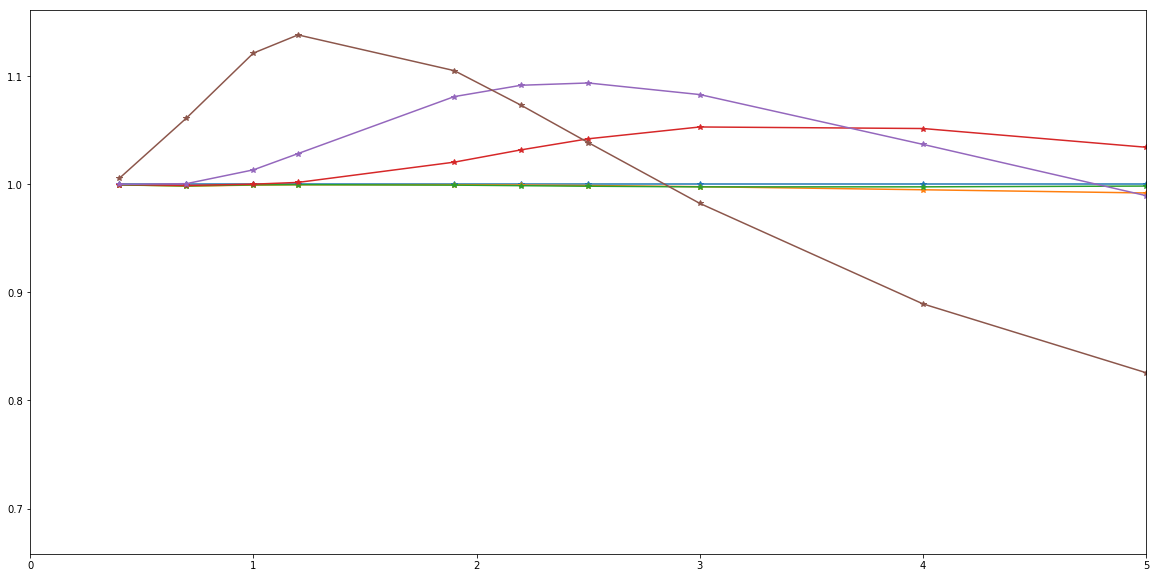

In [55]:
psi2, psi3, psi61, psi62, uz = read_Liu_Fig2a_results('try_ckeckInf2f')
psi6 = (psi61 + psi62) / 2
# psi2.plot()
# psi3.plot()
# (-psi6).plot()
# ft = -psi6 / psi3
# ut = ft / psi2
# at = ut.div(ut[0], axis=0)
# fig, ax0 = plt.subplots(1, 1, figsize=(20, 10))
# fig.patch.set_facecolor('white')
# ax0.plot(at, '-*')
# ax0.set_xlim(0, 5)
# pass


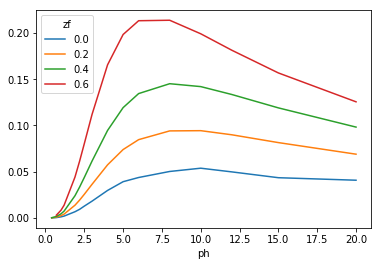

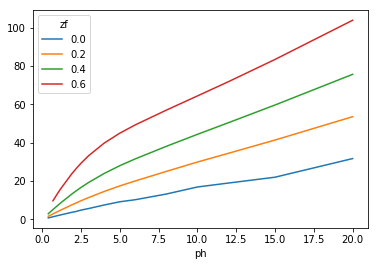

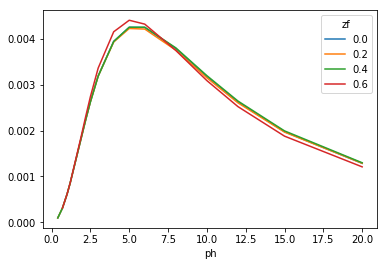

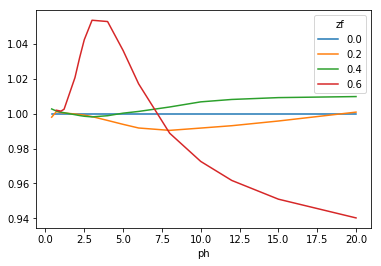

In [57]:
ft = -psi6 / psi3
ut = ft / psi2
at = ut.div(ut[0], axis=0)
ft.plot()
# ft.div(ft[0], axis=0).plot()
psi2.plot()
ut.plot()
at.plot()

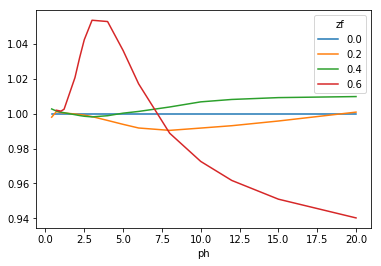

In [48]:
at.plot()